In [1]:
# 本章で共通して利用するライブラリの読み込み。
import unicodedata as ud
import re
import json
import pandas as pd
import numpy as np
import spacy
from spacy.lang.ja import Japanese

In [2]:
# コード 7.1 Unicode とそのエンコーディングである UTF-8 の関係を確認する
# ord()メソッドは、Unicodeをintで返し、hex()メソッドはそれを16進数に変換する。
print(hex(ord('a'))) # aのUnicodeは0x61
print(hex(ord('あ'))) # 「あ」のUnicodeは0x3042
# encode()メソッドはUTF-8のバイト列を返す。hex()関数はバイト列を16進数文字列に変換する。
print('a'.encode().hex()) # aという文字列はutf-8で16進数で61(これはUnicodeともASCIIコードとも同じである)。
print('あ'.encode().hex()) #  「あ」はutf-8では 0xe38182。Unicodeの0x3042が0xe38182にエンコーディングされている。
print('あ'.encode(encoding='shift_jis').hex()) # 「あ」のshift_jisは0x82a0。


0x61
0x3042
61
e38182
82a0


In [3]:
# コード 7.2 Unicode とそのエンコーディングである UTF-8 の関係を確認する
def cnormalize(str):
    for chr in str: # 一文字ずつ回す
        norm=ud.normalize('NFKC',chr)  # ここで互換等価性変換が実行される
        # 変換前(chr)後(norm)の文字とUTF-8コードを16進数で表示
        print(chr, chr.encode().hex(),'=>',
              norm,norm.encode().hex())
cnormalize('ｱ㎏Ａ９Ⅸ＄　㎡㈱．')

ｱ efbdb1 => ア e382a2
㎏ e38e8f => kg 6b67
Ａ efbca1 => A 41
９ efbc99 => 9 39
Ⅸ e285a8 => IX 4958
＄ efbc84 => $ 24
　 e38080 =>   20
㎡ e38ea1 => m2 6d32
㈱ e388b1 => (株) 28e6a0aa29
． efbc8e => . 2e


In [4]:
# コード 7.3 文字列置換を実行する2つの方法
text='年令が１８才になった令和元年に、1,000円寄付した。ｽｺﾞｲ!!'
print('text',text)
rep1=ud.normalize('NFKC',text)
print('rep1',rep1)
rep2=rep1.replace('年令','年齢').replace('元年','１年')
print('rep2',rep2)
mp=str.maketrans({'!':'！','。':'．'})
rep3=rep2.translate(mp)
print('rep3',rep3)

text 年令が１８才になった令和元年に、1,000円寄付した。ｽｺﾞｲ!!
rep1 年令が18才になった令和元年に、1,000円寄付した。スゴイ!!
rep2 年齢が18才になった令和１年に、1,000円寄付した。スゴイ!!
rep3 年齢が18才になった令和１年に、1,000円寄付した．スゴイ！！


In [5]:
# コード 7.4 全ての数字を'0'に変換することで抽象化する
print(re.sub('\d','0',rep3)) # \dは数字にマッチ => 連続する0を単一にしたい
print(re.sub('\d+','0',rep3)) # 連続する数字を0に => 桁数のカンマがとれない
print(re.sub('\d[\d,]*','0',rep3)) # [\d,]*で数字もしくはカンマの0回以上の繰り返し

年齢が00才になった令和0年に、0,000円寄付した．スゴイ！！
年齢が0才になった令和0年に、0,0円寄付した．スゴイ！！
年齢が0才になった令和0年に、0円寄付した．スゴイ！！


In [6]:
# コード 7.5 全ての URL を置換する処理
# 参考:https://gist.github.com/gruber/249502
reserved=r";/\?:@&=\+\$," # URLの構造を表現するための予約語
alphanum=r'0-9A-Za-z' # アルファベットと数字
mark=r"\-_\.!~\*\'\(\)" # reserved以外の記号
unreserved=alphanum + mark
escaped ="%" # 非ASCII文字を表現するためのエスケープ文字
fragment="#" # フラグメント識別子
uric=reserved + unreserved + escaped + fragment
rexp=r'https?://[%s]+'%uric
# 上の８行をまとめる書き方
# rexp=r'https?://[;/\?:@&=\+\$,0-9A-Za-z\-_\.!~\*\'\(\)%#]+'
print(rexp)

text='''
朝倉書店のURLは、https://www.asakura.co.jp/です。
wikipediaのページはhttps://ja.wikipedia.org/wiki/%E3%83%A1%E3%82%A4%E3%83%B3%E3%83%9A%E3%83%BC%E3%82%B8
ローカルでJupyterを起動するにはhttp://127.0.0.1:8888/?token=075dと入力すればよい。
'''
print(text)
print(re.sub(rexp,'www.example.com',text))

https?://[;/\?:@&=\+\$,0-9A-Za-z\-_\.!~\*\'\(\)%#]+

朝倉書店のURLは、https://www.asakura.co.jp/です。
wikipediaのページはhttps://ja.wikipedia.org/wiki/%E3%83%A1%E3%82%A4%E3%83%B3%E3%83%9A%E3%83%BC%E3%82%B8
ローカルでJupyterを起動するにはhttp://127.0.0.1:8888/?token=075dと入力すればよい。


朝倉書店のURLは、www.example.comです。
wikipediaのページはwww.example.com
ローカルでJupyterを起動するにはwww.example.comと入力すればよい。



In [7]:
# コード 7.6 文章を句読点で切り出す処理
# 文章を分割する。
def splitSentence(text):
    sentences=[] # このリストに区切った文章を格納する
    start=0 # 文章の開始位置
    skip=False # 括弧の中にいるかどうかのフラグ
    for i,c in enumerate(text):
        if c=='「': # 開始引用符なら
            skip=True
        elif c=='」': # 終了引用符なら
            skip=False
        elif not skip and c in '。？！': # 句読点の判断
            sentence=text[start:i+1] # 文章の切り出し(スライシング) 
            sentences.append(sentence.replace('\n','')) # 改行文字を消してリストに格納
            start=i+1 # 次の文章の開始位置セット
    return sentences

text='''「データの分析」はデータの散らばりと相関について教え、その目的は
「統計の基本的な考えを理解するとともに，それを用いてデータを整理
・分析し傾向を把握できるようにする。」である。総務省統計局では「
学校における統計教育の位置づけ」を解説し、指導者の支援にあたって
いる。
'''
print(text)
sentences=splitSentence(text)
sentences


「データの分析」はデータの散らばりと相関について教え、その目的は
「統計の基本的な考えを理解するとともに，それを用いてデータを整理
・分析し傾向を把握できるようにする。」である。総務省統計局では「
学校における統計教育の位置づけ」を解説し、指導者の支援にあたって
いる。



['「データの分析」はデータの散らばりと相関について教え、その目的は「統計の基本的な考えを理解するとともに，それを用いてデータを整理・分析し傾向を把握できるようにする。」である。',
 '総務省統計局では「学校における統計教育の位置づけ」を解説し、指導者の支援にあたっている。']

In [8]:
# コード 7.7 Spacy による形態素解析

sentenceJP=u'国境の長いトンネルを抜けるとそこは雪国だった。'
sentenceEN=u'The train came out of the long tunnel into the snow country.'
# 日本語と英語の言語処理クラスを設定する。
# 英語と日本語で設定が違うが、英語でもで
# from spacy.lang.en import Englishにて
# nlpEN=English()
# で実行可能ではあるが、一部データが出力されないので、spacy.loadにて別に設定された言語処理クラスをセットしている。
nlpJP = Japanese()
nlpEN = spacy.load('en_core_web_sm')
# 形態素解析の実行
tokensJP=nlpJP(sentenceJP)
tokensEN=nlpEN(sentenceEN)
print('token 番号,表層形,品詞,品詞細分類,原型')
for token in tokensJP:
    print(token.i,token.orth_,token.pos_,token.tag_,token.lemma_)
for token in tokensEN:
    print(token.i,token.orth_,token.pos_,token.tag_,token.lemma_)

token 番号,表層形,品詞,品詞細分類,原型
0 国境 NOUN 名詞-普通名詞-一般 国境
1 の ADP 助詞-格助詞 の
2 長い ADJ 形容詞-一般 長い
3 トンネル NOUN 名詞-普通名詞-サ変可能 トンネル
4 を ADP 助詞-格助詞 を
5 抜ける VERB 動詞-非自立可能 抜ける
6 と SCONJ 助詞-接続助詞 と
7 そこ PRON 代名詞 そこ
8 は ADP 助詞-係助詞 は
9 雪国 NOUN 名詞-普通名詞-一般 雪国
10 だっ AUX 助動詞 だ
11 た AUX 助動詞 た
12 。 PUNCT 補助記号-句点 。
0 The DET DT the
1 train NOUN NN train
2 came VERB VBD come
3 out SCONJ IN out
4 of ADP IN of
5 the DET DT the
6 long ADJ JJ long
7 tunnel NOUN NN tunnel
8 into ADP IN into
9 the DET DT the
10 snow NOUN NN snow
11 country NOUN NN country
12 . PUNCT . .


In [9]:
# コード 2.5を再掲
# NewsAPIを使ってニュースデータをダウンロードする

import urllib.parse
import urllib.request

# news apiを使ったニュースのダウンロード(https://newsapi.org/) 2020/07現在
#   Developer plan
#   検索期間：１ヶ月前〜1時間前
#   リクエスト数：500/日
# params (辞書で与える) 以下は指定可能な主なパラメータ(https://newsapi.org/docs/endpoints/everything#sources)
#   apiKey: 個人で取得したnews apiのapi key(必須)
#   q: titleとbodyのキーワードやフレーズ検索, AND/OR/NOTが使える ex. (ビール OR ワイン) AND 夏
#   qInTitle: タイトルのみを検索する。書式はqに同じ
#   language: 言語 (en,jpなど) デフォルトは全言語
#   from,to: 検索期間(デフォルト: 契約planの最古と最新日) ex. from=2020-07-09
#   pageSize: 取得する記事数
#   domains: 取得する記事元のURLのドメイン(カンマで区切って複数指定可能)
#   sortBy: relevancy, popularity, publishedAt(デフォルト)
def downloadNews(params,jsonFile):
    url='http://newsapi.org/v2/everything'
    requestStr=url+'?'+ urllib.parse.urlencode(params)
    print(requestStr)
    urllib.request.urlretrieve(requestStr,jsonFile)
    
params = {'language':'jp',
          'pageSize':50,
          'qInTitle':'株価',
          'domains': 'yahoo.co.jp',
          'apiKey':'738de6a2d0df4ecdabac05880b590273'
         }
downloadNews(params,'./stock_yahoo.json')


http://newsapi.org/v2/everything?language=jp&pageSize=50&qInTitle=%E6%A0%AA%E4%BE%A1&domains=yahoo.co.jp&apiKey=738de6a2d0df4ecdabac05880b590273


In [22]:
# コード 7.9 JSON からニュースタイトルを抜き出し、形態素解析してる単語-品詞ペアのリストを作成する
 
def delMedia(title):
    if title[-1]=='）': # タイトルの末尾に括弧がなければメディアは記載なしと判断
        match=re.findall(r'（.*?）',title)
        if len(match)>0:
            title=title.replace(match[-1],'')
    return title

# JSONの読み込み
with open('./stock_yahoo.json',encoding='utf-8') as fpr:
    dat=json.load(fpr)
 
nlp = Japanese()
results=[]
for news in dat['articles']:
    title=delMedia(news['title'])
    tokens=nlp(title)
    results.append([(token.lemma_,token.pos_) for token in tokens])
print(results[:2])

[[('株価', 'NOUN'), ('急落', 'NOUN'), ('の', 'ADP'), ('「', 'PUNCT'), ('パーク24', 'PROPN'), ('」', 'PUNCT'), ('見直', 'NOUN'), ('しー', 'SCONJ'), ('カーシェア', 'NOUN'), ('好調', 'NOUN'), ('、', 'PUNCT'), ('「', 'PUNCT'), ('シェアリング', 'NOUN'), ('エコノミー', 'NOUN'), ('」', 'PUNCT'), ('成長', 'NOUN'), ('株', 'NOUN'), ('と', 'ADP'), ('する', 'VERB'), ('て', 'SCONJ'), ('評価', 'NOUN')], [('クラウド', 'NOUN'), ('データ', 'NOUN'), ('ウェアハウス', 'NOUN'), ('の', 'ADP'), ('snowflake', 'NOUN'), ('、', 'PUNCT'), ('上場', 'NOUN'), ('初日', 'NOUN'), ('の', 'ADP'), ('株価', 'NOUN'), ('が', 'ADP'), ('急騰', 'NOUN')]]


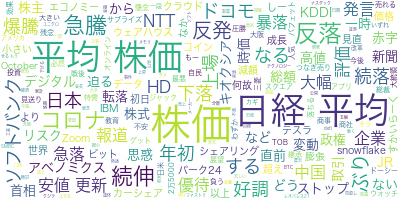

In [11]:
# コード 7.10 NewsAPI により取得したタイトルをワードクラウドで視覚化する方法
# github: https://github.com/amueller/word_cloud
# ドキュメント: http://amueller.github.io/word_cloud/index.html
import wordcloud
from IPython.display import Image

all_words=[] # 全ての単語をlistにフラットに格納する
for tokens in results:
    all_words+=[token[0] for token in tokens]
splitted = ' '.join(all_words) # 単語のスペース区切りがword cloudの入力形式

# for Mac
#font_path = "/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc"
# for Windows
font_path = "/c/Windows/Fonts/yumin.ttf"

#分割テキストからwordcloudを生成
wordc = wordcloud.WordCloud(font_path=font_path,background_color='white').generate(splitted)
wordc.to_file('./wordcloud.png') #画像ファイルとして保存
Image('./wordcloud.png') # 表示

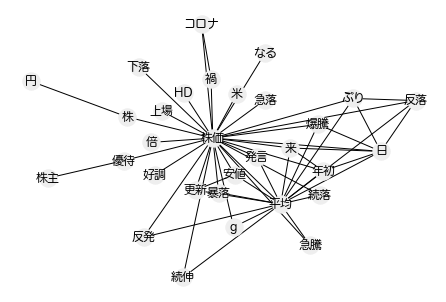

In [12]:
# コード 7.11 2タイトル以上に共起する単語の共起ネットワーク
# 先行実行コード：コード7.9
import networkx as nx
import matplotlib.pyplot as plt 

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

tbl=[] # sentence番号とwordの表を作成する
for i,sentence in enumerate(results):
    for token in sentence:
        # 対象は名詞と動詞だけとする
        if token[1]=='NOUN' or token[1]=='VERB':
            # iは文書(タイトル)番号
            tbl.append([i,token[0]])

df=pd.DataFrame(tbl,columns=['sentenceNo','word'])
cross=pd.crosstab(df['sentenceNo'], df['word']) # 図8.5のクロス集計表
matrix = cross.T.dot(cross) # この計算で単語間の共起件数(タイトル数)が計算される
# 共起頻度>3の行番号と列番号とその値をpairs変数にセット
# pairsはネットワークのエッジとなる
indices = np.where(matrix.values >= 3)
pairs=[]
for row, col in zip(*indices):
    if row<col: # 下三角のみを対象とする
        pairs.append([matrix.index[row],matrix.columns[col],matrix.iat[row,col]])
# エッジデータを一旦pandasのDataFrameに変換し、NetworkxのグラフオブジェクトGを生成
pairs=pd.DataFrame(pairs,columns=['source','target','weight'])
G = nx.from_pandas_edgelist(pairs, edge_attr=True)
pos = nx.kamada_kawai_layout(G) # グラフレイアウト
nx.draw(G, pos, with_labels=True,node_color='#eeeeee') # 描画
plt.show()


In [13]:
# 章末問題 1) メールアドレスの正規表現
# 参考URL http://srgia.com/docs/rfc5322j.html (2020/09/11アクセス)
# addr-spec  = local-part "@" domain (注1)
# local-part = dot-atom / quoted-string (注2) / obs-local-part (注3)
# domain     = dot-atom / domain-literal (注4) / obs-domain (注3)
# atext      =   ALPHA / DIGIT /    ; Printable US-ASCII
#                "!" / "#" /        ;  specials を除く文字
#                "$" / "%" /        ;  atom に使用される
#                "&" / "'" /
#                "*" / "+" /
#                "-" / "/" /
#                "=" / "?" /
#                "^" / "_" /
#                "`" / "{" /
#                "|" / "}" /
#                "~"
#   atom            =   [CFWS] 1*atext [CFWS] (注5)
#   dot-atom-text   =   1*atext *("." 1*atext)
#   dot-atom        =   [CFWS] dot-atom-text [CFWS]

# 注1) ABNF記法で書かれており、https://ja.wikipedia.org/wiki/ABNF を参照のこと。
# 注2) quoted-string: ダブルクォーテーションを用いるとatextの記号類以外も含むことができるが、まずお目にかかることはないので対応していない。
# 注3) obs-* : 廃止された文法なのでここでは対応せず
# 注4) domain-literal : [192.168.0.1] のようなIPアドレスによる表現だが、これもまずお目にかかることはないので対応していない。
# 注5) CFWSは空白の折返しや()で囲われたコメントのことで、アドレスの途中で改行するなどの表記も可能となるが、atomそのものではない。

atext=r"[a-zA-Z0-9\!#\$%&'\*\+-/=\?\^_`\{\|\}~]"
dot_atom_text=atext + '+' +'(\.' + atext + '+)*'
domain=dot_atom_text + '@' + dot_atom_text
# print(dot_atom_text)
# [a-zA-Z0-9\!#\$%&'\*\+-/=\?\^_`\{\|\}~]+(\.[a-zA-Z0-9\!#\$%&'\*\+-/=\?\^_`\{\|\}~]+)*
# print(domain)
# [a-zA-Z0-9\!#\$%&'\*\+-/=\?\^_`\{\|\}~]+(\.[a-zA-Z0-9\!#\$%&'\*\+-/=\?\^_`\{\|\}~]+)*@[a-zA-Z0-9\!#\$%&'\*\+-/=\?\^_`\{\|\}~]+(\.[a-zA-Z0-9\!#\$%&'\*\+-/=\?\^_`\{\|\}~]+)*

text='''
朝倉書店へのメールアドレスは、info@asakura.co.jpです。
Mail to abc <abc@example.com>
'''
print(text)
print(re.sub(domain,'hoge@example.com',text))



朝倉書店へのメールアドレスは、info@asakura.co.jpです。
Mail to abc <abc@example.com>


朝倉書店へのメールアドレスは、hoge@example.comです。
Mail to abc <hoge@example.com>



In [14]:
# 章末問題 2) パラグラフ別に文章を分割する。
def splitParaSentence(text):
    sentences=[] # このリストに区切った文章を格納する
    paras=text.split('\n') # 改行で分割してしまう。
    for pNo,para in enumerate(paras):
        start=0 # 文章の開始位置
        sNo=0 # 文章番号
        skip=False # 括弧の中にいるかどうかのフラグ
        # 以下はコード8.6とほぼ同じ(改行を削除する処理はない)
        for i,c in enumerate(para):
            if c=='「': # 開始引用符なら
                skip=True
            elif c=='」': # 終了引用符なら
                skip=False
            elif not skip and c in '。？！': # 句読点の判断
                sentence=para[start:i+1] # 文章の切り出し(スライシング) 
                sentences.append([pNo,sNo,sentence]) # リストに格納
                sNo+=1
                start=i+1 # 次の文章の開始位置セット
    return sentences

# 夏目漱石「それから」の冒頭
# https://www.aozora.gr.jp/cards/000148/files/56143_50921.html
text='''誰か慌あわただしく門前を馳かけて行く足音がした時、代助だいすけの頭の中には、大きな俎下駄まないたげたが空くうから、ぶら下っていた。けれども、その俎下駄は、足音の遠退とおのくに従って、すうと頭から抜け出して消えてしまった。そうして眼が覚めた。
枕元まくらもとを見ると、八重の椿つばきが一輪畳の上に落ちている。代助は昨夕ゆうべ床の中で慥たしかにこの花の落ちる音を聞いた。彼の耳には、それが護謨毬ゴムまりを天井裏から投げ付けた程に響いた。夜が更ふけて、四隣あたりが静かな所為せいかとも思ったが、念のため、右の手を心臓の上に載せて、肋あばらのはずれに正しく中あたる血の音を確かめながら眠ねむりに就いた。
'''
sentences=splitParaSentence(text)
sentences

[[0, 0, '誰か慌あわただしく門前を馳かけて行く足音がした時、代助だいすけの頭の中には、大きな俎下駄まないたげたが空くうから、ぶら下っていた。'],
 [0, 1, 'けれども、その俎下駄は、足音の遠退とおのくに従って、すうと頭から抜け出して消えてしまった。'],
 [0, 2, 'そうして眼が覚めた。'],
 [1, 0, '枕元まくらもとを見ると、八重の椿つばきが一輪畳の上に落ちている。'],
 [1, 1, '代助は昨夕ゆうべ床の中で慥たしかにこの花の落ちる音を聞いた。'],
 [1, 2, '彼の耳には、それが護謨毬ゴムまりを天井裏から投げ付けた程に響いた。'],
 [1,
  3,
  '夜が更ふけて、四隣あたりが静かな所為せいかとも思ったが、念のため、右の手を心臓の上に載せて、肋あばらのはずれに正しく中あたる血の音を確かめながら眠ねむりに就いた。']]

In [15]:
# 章末問題 3) 日本語のSTOP WORDを除外

sentenceJP=u'国境の長いトンネルを抜けるとそこは雪国だった。'
taggerJP = Japanese()
tokensJP=taggerJP(sentenceJP)
print('token 番号,表層形,品詞,品詞細分類,原型')
for token in tokensJP:
    # STOP_WORDSは集合型(set)で、そこに単語が入っていないことは'not in'で判定できる。
    if token.lemma_ not in spacy.lang.ja.stop_words.STOP_WORDS:
        print(token.i,token.orth_,token.pos_,token.tag_,token.lemma_)
    

token 番号,表層形,品詞,品詞細分類,原型
0 国境 NOUN 名詞-普通名詞-一般 国境
2 長い ADJ 形容詞-一般 長い
3 トンネル NOUN 名詞-普通名詞-サ変可能 トンネル
5 抜ける VERB 動詞-非自立可能 抜ける
9 雪国 NOUN 名詞-普通名詞-一般 雪国
12 。 PUNCT 補助記号-句点 。


In [16]:
# 章末問題 4) 英語のSTOP WORDを除外

sentenceEN=u'The train came out of the long tunnel into the snow country.'
taggerEN = spacy.load('en_core_web_sm')
tokensEN=taggerEN(sentenceEN)
print('token 番号,表層形,品詞,品詞細分類,原型')
for token in tokensEN:
    # lower()で大文字は全て小文字に変換する。
    if token.lemma_.lower() not in spacy.lang.en.stop_words.STOP_WORDS:
        print(token.i,token.orth_,token.pos_,token.tag_,token.lemma_)
    

token 番号,表層形,品詞,品詞細分類,原型
1 train NOUN NN train
2 came VERB VBD come
6 long ADJ JJ long
7 tunnel NOUN NN tunnel
10 snow NOUN NN snow
11 country NOUN NN country
12 . PUNCT . .


In [17]:
# 章末問題 5) さまざまな形態素解析のツール

# GitHub: https://mocobeta.github.io/janome/
# リファレンス: https://mocobeta.github.io/janome/api/index.html
# 解説: https://github.com/mocobeta/janome
from janome.tokenizer import Tokenizer
from pprint import pprint
def tokenizeJanome(sentence,tagger):
    words=[]
    tokens=tagger.tokenize(sentence)
    for tNo,token in enumerate(tokens):
        #tokens=[str(token) for token in tokens]
        #print('表層形',token.surface)
        #print('品詞',token.part_of_speech.split(','))
        #print('活用形',token.infl_form)
        #print('活用型',token.infl_type)
        #print('node_type',token.node_type)
        #print('原型',token.base_form)
        #print('発音',token.phonetic)
        #print('読み',token.reading)
        words.append([tNo,token.surface,token.base_form,token.part_of_speech.split(',')[0]])
    return words

# GitHub: https://github.com/taishi-i/nagisa
# 文書: https://nagisa.readthedocs.io/en/latest/?badge=latest
import nagisa
def tokenizeNagisa(sentence):
    words=[]
    nagi = nagisa.tagging(sentence)
    surface=nagi.words
    postags=nagi.postags
    for tNo,token in enumerate(zip(surface,postags)):
        words.append([tNo,token[0],None,token[1]])
    return words

# HP: http://taku910.github.io/mecab/
import MeCab
def tokenizeMecab(sentence,tagger):
    words=[]
    node = tagger.parseToNode(sentence)
    tNo=0
    while node:
        features=node.feature.split(',')
        #print(features)
        #print('表層形',node.surface)
        #print('品詞',features[0])
        #print('品詞細分類1',features[1])
        #print('品詞細分類2',features[2])
        #print('品詞細分類3',features[3])
        #print('活用型',features[4])
        #print('活用形',features[5])
        #print('原型',features[6])
        #print('読み',features[7])
        #print('発音',features[8])
        words.append([tNo,node.surface, features[6], features[0]])
        node = node.next
        tNo+=1
    return words

# HP: http://nlp.ist.i.kyoto-u.ac.jp/index.php?JUMAN++
from pyknp import Juman
def tokenizeJuman(sentence):
    words=[]
    jumanpp = Juman()
    result = jumanpp.analysis(sentence)
    # print(result.mrph_list())
    for tNo,node in enumerate(result.mrph_list()): # 各形態素にアクセス
        #print('表層形',node.midasi)
        #print('品詞',node.hinsi)
        #print('品詞細分類',node.bunrui)
        #print('活用型',node.katuyou1)
        #print('活用形',node.katuyou2)
        #print('原型',node.genkei)
        #print('読み',node.yomi)
        #print('意味情報',node.imis)
        #print('代表表記',node.repname)
        words.append([tNo,node.midasi, node.genkei, node.hinsi])
    return words

doc=u'国境の長いトンネルを抜けるとそこは雪国だった。'

print('## Janome')
tagger = Tokenizer()
words=tokenizeJanome(doc,tagger)
print(words)
    
print('## Nagisa')
words=tokenizeNagisa(doc)
print(words)

print('## MeCab')
tagger = MeCab.Tagger()
words=tokenizeMecab(doc,tagger)
print(words)

print('## JUMAN')
words=tokenizeJuman(doc)
print(words)


## Janome
[[0, '国境', '国境', '名詞'], [1, 'の', 'の', '助詞'], [2, '長い', '長い', '形容詞'], [3, 'トンネル', 'トンネル', '名詞'], [4, 'を', 'を', '助詞'], [5, '抜ける', '抜ける', '動詞'], [6, 'と', 'と', '助詞'], [7, 'そこ', 'そこ', '名詞'], [8, 'は', 'は', '助詞'], [9, '雪国', '雪国', '名詞'], [10, 'だっ', 'だ', '助動詞'], [11, 'た', 'た', '助動詞'], [12, '。', '。', '記号']]
## Nagisa
[[0, '国境', None, '名詞'], [1, 'の', None, '助詞'], [2, '長い', None, '形容詞'], [3, 'トンネル', None, '名詞'], [4, 'を', None, '助詞'], [5, '抜ける', None, '動詞'], [6, 'と', None, '助詞'], [7, 'そこ', None, '代名詞'], [8, 'は', None, '助詞'], [9, '雪国', None, '名詞'], [10, 'だっ', None, '助動詞'], [11, 'た', None, '助動詞'], [12, '。', None, '補助記号']]
## MeCab
[[0, '', '*', 'BOS/EOS'], [1, '国境', '国境', '名詞'], [2, 'の', 'の', '助詞'], [3, '長い', '長い', '形容詞'], [4, 'トンネル', 'トンネル', '名詞'], [5, 'を', 'を', '助詞'], [6, '抜ける', '抜ける', '動詞'], [7, 'と', 'と', '助詞'], [8, 'そこ', 'そこ', '名詞'], [9, 'は', 'は', '助詞'], [10, '雪国', '雪国', '名詞'], [11, 'だっ', 'だ', '助動詞'], [12, 'た', 'た', '助動詞'], [13, '。', '。', '記号'], [14, '', '*', 'BOS/EOS']]
## JUMAN
[[0, '

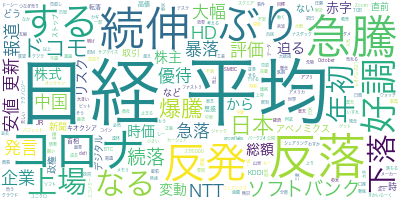

In [23]:
# 章末問題 6) '株価'をstopwordsに指定してWord Cloudを描画する
# コード 8.10 NewsAPI により取得したタイトルをワードクラウドで視覚化する方法
# github: https://github.com/amueller/word_cloud
# ドキュメント: http://amueller.github.io/word_cloud/index.html
import wordcloud
from IPython.display import Image


all_words=[] # 全ての単語をlistにフラットに格納する
for tokens in results:
    all_words+=[token[0] for token in tokens]
    # WordCloudを実行する時にstopwordsを指定するやり方以外であれば、次のコメントのようにしてもよい
    # all_words+=[token[0] for token in tokens if token[0] not in ['株価']]
splitted = ' '.join(all_words) # 単語のスペース区切りがword cloudの入力形式

# for Mac
#font_path = "/System/Library/Fonts/ヒラギノ角ゴシック W3.ttc"
# for Windows
font_path = "/c/Windows/Fonts/yumin.ttf"

## stopwords=に表示させたくない単語を列挙すれば良い。
wordc = wordcloud.WordCloud(font_path=font_path,background_color='white',stopwords=['株価']).generate(splitted)
wordc.to_file('./wordcloud.png') #画像ファイルとして保存
Image('./wordcloud.png') # 表示

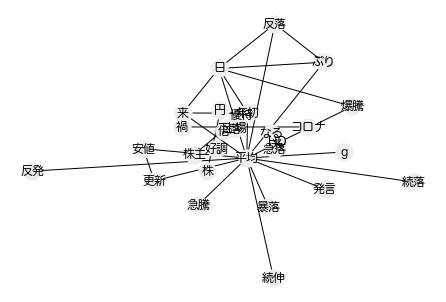

In [19]:
# 章末問題 7) コード8.11のグラフから、「株価」ノードを削除して描画
# 先行実行コード：コード8.11 

G2=G.copy() # ノードを削除するので、元のグラフに影響しないようにコピーしておく。
G2.remove_node('株価') # 株価ノードの削除

# 描画方法は8.11と同じ
pos = nx.kamada_kawai_layout(G2) # グラフレイアウト
nx.draw(G2, pos, with_labels=True,node_color='#eeeeee') # 描画
plt.show()

['HD', '株価', 'g', '平均', 'なる', 'ぶり', '反落', '日', 'コロナ', '禍', '上場', '下落', '倍', '優待', '株主', '円', '株', '反発', '好調', '安値', '更新', '年初', '急騰', '暴落', '来', '爆騰', '発言', '続伸', '続落', '急落', '米']
[('HD', '株価'), ('株価', 'g'), ('株価', 'なる'), ('株価', 'ぶり'), ('株価', 'コロナ'), ('株価', '上場'), ('株価', '下落'), ('株価', '倍'), ('株価', '優待'), ('株価', '反発'), ('株価', '反落'), ('株価', '好調'), ('株価', '安値'), ('株価', '平均'), ('株価', '年初'), ('株価', '急落'), ('株価', '急騰'), ('株価', '日'), ('株価', '暴落'), ('株価', '更新'), ('株価', '来'), ('株価', '株'), ('株価', '爆騰'), ('株価', '発言'), ('株価', '禍'), ('株価', '米'), ('株価', '続伸'), ('株価', '続落'), ('g', '平均'), ('平均', 'ぶり'), ('平均', '反発'), ('平均', '反落'), ('平均', '安値'), ('平均', '年初'), ('平均', '急騰'), ('平均', '日'), ('平均', '暴落'), ('平均', '更新'), ('平均', '来'), ('平均', '爆騰'), ('平均', '発言'), ('平均', '続伸'), ('平均', '続落'), ('ぶり', '反落'), ('ぶり', '日'), ('反落', '日'), ('日', '年初'), ('日', '来'), ('日', '爆騰'), ('コロナ', '禍'), ('優待', '株主'), ('円', '株'), ('安値', '更新'), ('年初', '来')]


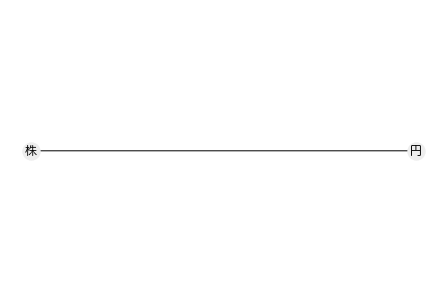

In [20]:
# 章末問題 8) コード8.11のグラフで、「円」ノードおよび、その隣接ノードから構成される部分グラフを描画
# 先行実行コード：コード8.11 

print(G.nodes) # ノード一覧
print(G.edges) # エッジ一覧

# 「円」に隣接するノード集合。「円」そのものは含まれていないことに注意する。
nei=list(G['円'])
# print(nei)
# ['一時', '以上', '意向', '株価', '辞任']

# 隣接ノードに「円」自体のノードも加えて部分グラフ(誘導部分グラフ)を求める。
G3=nx.subgraph(G,nei+['円'])

# 描画
pos = nx.kamada_kawai_layout(G3) # グラフレイアウト
nx.draw(G3, pos, with_labels=True,node_color='#eeeeee') # 描画
plt.show()


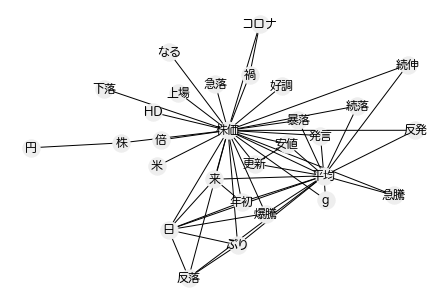

In [21]:
# 章末問題 9) mlxtenライブラリの頻出アイテム集合列挙の機能を使って単語の共起ネットワークを描画
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
import matplotlib.pyplot as plt 
tbl=[] # sentence番号とwordの表を作成する
for i,sentence in enumerate(results):
    for token in sentence:
        # 対象は名詞と動詞だけとする
        if token[1]=='NOUN' or token[1]=='VERB':
            # iは文書(タイトル)番号
            tbl.append([i,token[0],False]) # 値をFalseにしているのは、後でisnull()を使うから

df=pd.DataFrame(tbl,columns=['sentenceNo','word','occur'])
# print(df)
#      sentenceNo         word  occur
# 0             0           株価  False
# 1             0         フォール  False
#                   :
# 11            1         アップル  False
# 12            1           株式  False
#                   :

# pivot_tableを使えば、sentenceNoを行に、wordを列にした行列に変換可能
dfw=df.pivot_table(index='sentenceNo',columns='word',values='occur')
# dfwのイメージ
#   単語1 単語2 単語3 ...
# 0 NaN   False NaN
# 1 NaN   NaN   False
# 2 False NaN   NaN

# 元々、出現しているセルにはFalseが入っていた。
# isnull()で単語が出現していないセルをTrueに変換する。
# そして 否定演算子でTrueとFalseを反転させてmlxtend用の入力データが出来上がり
dfw=~dfw.isnull() 
# dfwのイメージ
#   単語1 単語2 単語3 ...
# 0 False True  False
# 1 False False True
# 2 True  False False

# mlxtendでは、3件以上のペアを抜き出すという指定ができず、確率(support)で指定しなければならない。
# そこで、文章の総件数を求めておいて、3件の出現確率を求めている。
supp=3/len(dfw.index)

# ここで3件以上共起する単語集合を列挙している。
# ただし、max_len=2を指定しているので、単語集合のサイズの上限は2に制限している。
# min_len=の指定はできないので、次のステップで削除している。
# use_colnames=Trueを指定しないと列番号での出力になってしまう。
freqPairs = fpgrowth(dfw, min_support=supp, use_colnames=True,max_len=2)
#print(freqPairs)
#     support   itemsets
# 0      0.90       (株価)
# 1      0.14       (一時)
# 2      0.12       (下落)
#             :
# 65     0.08   (株価, 水準)
# 66     0.06  (コロナ, 水準)
# 67     0.06    (前, 水準)

## コメント：
# コード8.11 の「matrix = cross.T.dot(cross) 」この部分を相関ルール導出ツールmlxtendによって実装したのだが、
# 相関ルールの方法を使う利点は、もしそのツールがデータを疎行列形式で直接扱うことができれば、メモリを大幅に節約できる点にある。
# しかし、結局、mlxtendでも「文章数×単語数」の行列は作成しており、消費メモリ量の観点からはさほど効果はない。
# Pandasには疎行列形式を扱うことができるが、一旦は行列を作って、それを疎行列に変換するので、これもさほどの効果はない。
# また行列を作らずに疎行列を作ることも可能であるが、プログラミング的に複雑になってくる。
# nysol_pythonのTakeパッケージでは、内部で疎行列で処理するのでメモリ効率は高いので参照されたい。

# 上記の結果から、2単語ペアのみを抜き出し、エッジデータを作成する。
pairs=[]
for i,line in freqPairs.iterrows():
    itemset=list(line['itemsets'])
    if len(itemset)==2:
        pairs.append([itemset[0],itemset[1],line['support']])
# エッジデータを一旦pandasのDataFrameに変換し、NetworkxのグラフオブジェクトG4を生成
pairs=pd.DataFrame(pairs,columns=['source','target','weight'])
G4 = nx.from_pandas_edgelist(pairs, edge_attr=True)
pos = nx.kamada_kawai_layout(G4) # グラフレイアウト
nx.draw(G4, pos, with_labels=True,node_color='#eeeeee') # 描画
plt.show()